In [1]:
print("------ IMPORT LIBRARY ------")

import warnings; warnings.filterwarnings('ignore')
from nilmtk import DataSet
from rnndisaggregator import RNNDisaggregator
from nilmtk.datastore import HDFDataStore
import matplotlib.pyplot as plt
import metrics

# skip if you already have .h5 dataset
# from nilmtk.dataset_converters import convert_ukdale
# convert_ukdale('./data/REDD/low_freq', './data/REDD/redd.h5') 


------ IMPORT LIBRARY ------


Using TensorFlow backend.
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4785: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/caim03/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))


In [2]:
print("------ SET GLOBAL VARIABLES ------")

DATASET = "../data/UKDALE/ukdale.h5" # path of ukdale data
MODEL = "../data/UKDALE/microwave-model-ukdale.h5" # path of model
DISAG_FILE = "../data/UKDALE/microwave-disag-out.h5" # path of disaggregation output
APPLIANCE = 'microwave' # the network will be trained on this appliance
SAMPLE_PERIOD = 6 # sample period (6 seconds in ukdale dataset)

WINDOWS = {
    'train': {
        1: ("2013-04-12", "2015-07-01"),
        2: ("2013-05-22", "2013-10-03 06:16:00"),
    },
    'test': {
        5: ("2014-06-29", "2014-10-21")
    }
}

# True if the model must be trained
TRAINING = True

------ SET GLOBAL VARIABLES ------


In [3]:
print("------ PREPARING DATA ------")

train_mainlist = []
train_meterlist = []

# for each building
for key in WINDOWS['train'].keys():
    train = DataSet(DATASET)
    train.set_window(start=WINDOWS['train'][key][0], end=WINDOWS['train'][key][1])
    train_elec = train.buildings[key].elec
    
    train_mainlist.append(train_elec.mains())
    train_meterlist.append(train_elec.submeters()[APPLIANCE])

------ PREPARING DATA ------


In [4]:
rnn = RNNDisaggregator()

if TRAINING:
    print("------ START TRAINING ------")
    rnn.train_across_buildings(train_mainlist, train_meterlist, epochs=5, sample_period=SAMPLE_PERIOD)
    rnn.export_model(MODEL)
else:
    print("------ IMPORT MODEL ------")
    rnn.import_model(MODEL)

------ START TRAINING ------


/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/nilmtk/utils.py:426: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


0


/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Batch 30206 of [142492, 30207]

1
Batch 30206 of [142492, 30207]

2
Batch 30206 of [142492, 30207]

3
Batch 30206 of [142492, 30207]

4
Batch 30206 of [142492, 30207]



In [5]:
print("------ PREPARING TEST DATA ------")
test = DataSet(DATASET)
test.set_window(start=WINDOWS['test'][5][0], end=WINDOWS['test'][5][1])
test_elec = test.buildings[5].elec
test_mains = test_elec.mains()

disag_filename = DISAG_FILE # The filename of the resulting datastore
output = HDFDataStore(disag_filename, 'w')

print("------ START DISAGGREGATION ------")
rnn.disaggregate(test_mains, output, train_meterlist[0], sample_period=SAMPLE_PERIOD)
output.close()

------ PREPARING TEST DATA ------
------ START DISAGGREGATION ------
New sensible chunk: 8367
New sensible chunk: 1968
New sensible chunk: 14832
New sensible chunk: 11385
New sensible chunk: 43784
New sensible chunk: 13526
New sensible chunk: 10790
New sensible chunk: 17916
New sensible chunk: 35283
New sensible chunk: 202
New sensible chunk: 22047
New sensible chunk: 946
New sensible chunk: 6596
New sensible chunk: 34952
New sensible chunk: 520
New sensible chunk: 24226
New sensible chunk: 115
New sensible chunk: 4401
New sensible chunk: 7380
New sensible chunk: 165
New sensible chunk: 691
New sensible chunk: 6034
New sensible chunk: 14776
New sensible chunk: 394
New sensible chunk: 2261
New sensible chunk: 11207
New sensible chunk: 163
New sensible chunk: 47380
New sensible chunk: 399
New sensible chunk: 1198
New sensible chunk: 184
New sensible chunk: 25519
New sensible chunk: 40976
New sensible chunk: 426
New sensible chunk: 2524
New sensible chunk: 177
New sensible chunk: 4586
New

------ PLOTTING PREDICTION AND GROUND TRUTH ------


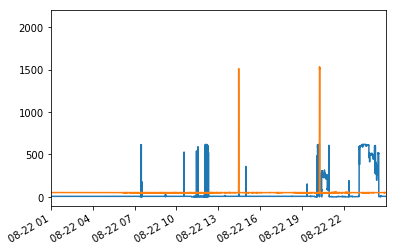

In [6]:
result = DataSet(disag_filename)
res_elec = result.buildings[5].elec
predicted = res_elec[APPLIANCE]
ground_truth = test_elec[APPLIANCE]

print("------ PLOTTING PREDICTION AND GROUND TRUTH ------")
predicted.power_series_all_data().plot()
ground_truth.power_series_all_data().plot()
# Change the limit to zoom-in or zoom-out the figure
plt.xlim('2014-08-22 00:00:00', '2014-08-22 23:59:00')
plt.show()

In [7]:
print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/nilmtk/datastore/hdfdatastore.py:128: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  stop=look_ahead_end_i)
/home/caim03/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/pandas/core/internals.py:2633: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return self.values.astype('datetime64[ns]').values


============ Relative error in total energy: 0.5184870286918685
============ Mean absolute error(in Watts): 49.26614867668397
